# Das AUVIS-System für die CHiME-9 Multi-Modal Context-aware Recognition (MCoRec) Challenge

## Installation

```
# Clone the auvis repo
git clone https://github.com/AudioVisual-Projekt/auvis.git
cd auvis_system

# Create Conda environment
conde create --prefix conda-env/mcorec python=3.11
conda activate conda-env/mcorec

# Install FFmpeg, if it's not already installed.
conda install ffmpeg

# Install dependencies
pip install -r requirements.txt

# Download and unzip the data and the models
# wget data-bin.zip
# unzip data-bin.zip
# wget model-bin.zip
# unzip model-bin.zip
```

## Imports

In [23]:
import os
import re
import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import roc_auc_score, average_precision_score

## Subtask 1: Active Speaker Detection

### ASD-Scores berechnen

Die ASD-Scores können über die `asd.py` im Ordner `script` berechnet werden. Standardmäßig wird dazu das Model `finetuning_TalkSet.model` verwendet, die Modell-Datei des Light-ASD-Modells. Um ein anderes Modell für die Berechnung verwenden zu können wurde das zusätzliche Argument `--model` implementiert. Zur Auswahl für dieses Attributs stehen neben der Modell-Datei für das Light-ASD-Modell, die des Light-Robust-ASD-Modells `finetuning_TalkSet_lrasd.model` sowie das auf dem MCoRec weitertrainierte Light-Robust-ASD-Modell `finetuning_MCoRec_5_epoch.model`.

Die Auswahl der zu verarbeiteten Sessions funktioniert über die Angabe des `dataset`. Diese Angabe kann entweder `dev` für den Entwicklungsdatensatz oder `train` für den Trainingsdatensatz sein. 

Zuletzt wird ein Ordner angegeben, in dem die berechneten ASD-Scores gespeichert werden sollen, damit bei der Berechnung mit verschiedenen Modellen die Scores nicht überschrieben, sondern separat gespeichert werden. Hier werden die Scores unter `data-bin/output/<name>` gespeichert. 

Im folgenden wird die Schleife für die Berechnung aller Tracks gezeigt. Aus zeittechnischen Gründen wird an dieser Stelle nur `session_42/spk_3/track_00` verarbeitet.

In [14]:
asd_models =  ["light_asd", "light_robust_asd", "mcorec_asd"]

dataset = "dev"
dataset_folder = f"data-bin/{dataset}"
 
sessions = os.listdir(dataset_folder) 
print(sessions)

session = "session_42"
speaker = "spk_3"
track = "track_00"

for model in asd_models: 

    if model == "light_asd":
        model_file = "finetuning_TalkSet.model"
        output_folder = "light_asd_scores"
    elif model == "light_robust_asd":
        model_file = "finetuning_TalkSet_lrasd.model"
        output_folder = "light_robust_asd_scores"
    elif model == "mcorec_asd":
        model_file = "finetuning_MCoRec_5_epoch.model"
        output_folder = "mcorec_asd_scores"

    for s in sessions:
    
        if s != session:
            continue
    
        print(s)
        session_speakers_path = f"{dataset_folder}/{s}/speakers"
        pattern = re.compile(r'^track_\d{2}\.mp4$')
        
        for spk in os.listdir(session_speakers_path):
    
            if spk != speaker:
                continue
        
            print(spk)
            speaker_files = os.listdir(f"{session_speakers_path}/{spk}/central_crops")
            speaker_tracks = [file for file in speaker_files if pattern.match(file)]
        
            for t in speaker_tracks:
    
                if t != f"{track}.mp4":
                    continue
        
                print(t)
                video_path = f"{session_speakers_path}/{spk}/central_crops/{t}"
                output_path = f"data-bin/output/{output_folder}/{dataset}/{s}/speakers/{spk}"
                !conda run -p conda-env/mcorec python script/asd.py --video {video_path} --output_dir {output_path} --model {model_file}

['session_138', 'session_132', 'session_43', 'session_49', 'session_50', 'session_57', 'session_44', 'session_135', 'session_40', 'session_53', 'session_54', 'session_136', 'session_141', 'session_134', 'session_56', 'session_51', 'session_133', 'session_139', 'session_48', 'session_42', 'session_140', 'session_137', 'session_55', 'session_52', 'session_41']
session_42
spk_3
track_00.mp4
02-18 19:54:09 Model para number = 1.02
Light-ASD-Model loaded successfully.
ASD results saved to: data-bin/output/light_asd_scores/dev/session_42/speakers/spk_3/track_00_asd.json

session_42
spk_3
track_00.mp4
02-18 19:54:27 Model para number = 0.84
Light-Robust-ASD-Model loaded successfully.
ASD results saved to: data-bin/output/light_robust_asd_scores/dev/session_42/speakers/spk_3/track_00_asd.json

session_42
spk_3
track_00.mp4
02-18 19:54:44 Model para number = 0.84
MCoRec-ASD-Model loaded successfully.
ASD results saved to: data-bin/output/mcorec_asd_scores/dev/session_42/speakers/spk_3/track_00_

### Binäre Label erstellen

Aus den `vtt`-Dateien müssen sowohl für das separat durchgeführte Training (siehe `subtask_1_additional_files/finetune_model.py`), als auch für den Vergleich der ASD-Scores geeignete Labels konstruiert werden. Benötigt wird pro Frame die Angabe, ob der jeweilige Sprecher spricht, oder nicht (NOT_SPEAKING/SPEAKING bzw. 0/1).

In [17]:
!conda run -p conda-env/mcorec python subtask_1_additional_files/vtt_to_csv_label.py

session_42
spk_3
track_00
Label gespeichert unter: data-bin/dev/session_42/labels/spk_3_track_00.csv



### ASD-Scores vergleichen

Die zuvor berechneten ASD-Scores aus den verschiedenen Modellen können nun mithilfe der Labels miteinander verglichen werden. 

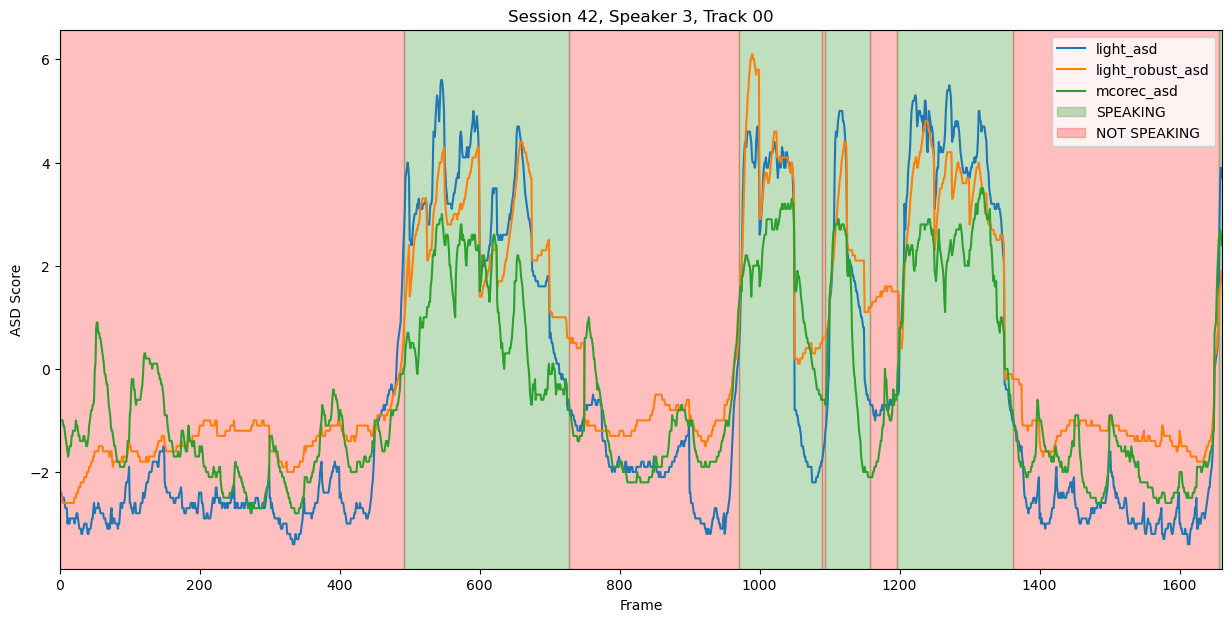

In [28]:
df = None

# ASD-Scores für alle Modelle laden und zusammenfügen
for i, model in enumerate(asd_models):
    asd_path = f"data-bin/output/{model}_scores/dev/{session}/speakers/{speaker}/{track}_asd.json"

    with open(asd_path, "r") as f:
        asd_scores = json.load(f)

    new_df = pd.DataFrame.from_dict(asd_scores, orient="index", columns=[model])

    if df is None:
        df = new_df
    else:
        df = df.join(new_df)

# Ground Truth hinzufügen
truth = pd.read_csv(f"data-bin/dev/{session}/labels/{speaker}_{track}.csv", index_col="frame")
truth.index = truth.index.astype(int)
df.index = df.index.astype(int)
df_merged = df.merge(truth, left_index=True, right_index=True, how="inner")


# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 7))

labels = df_merged["label"].values
x = df_merged.index.values  # frame

start = x[0]

for i in range(1, len(labels)):
    if labels[i] != labels[i - 1]:
        color = "green" if labels[i - 1] == 1 else "red"
        ax.axvspan(start, x[i], color=color, alpha=0.25, zorder=0)
        start = x[i]

color = "green" if labels[-1] == 1 else "red"
ax.axvspan(start, x[-1] + 1, color=color, alpha=0.25, zorder=0)

df_merged[
    ["light_asd", "light_robust_asd", "mcorec_asd"]
].plot(ax=ax, zorder=2)

ax.set_xlabel("Frame")
ax.set_ylabel("ASD Score")
ax.set_title(
    f"Session {session.split('_')[1]}, "
    f"Speaker {speaker.split('_')[1]}, "
    f"Track {track.split('_')[1]}"
)
ax.set_xlim(df_merged.index.min(), df_merged.index.max() + 1)

handles, labels = ax.get_legend_handles_labels()

speaking_patch = mpatches.Patch(
    color="green", alpha=0.25, label="SPEAKING"
)
not_speaking_patch = mpatches.Patch(
    color="red", alpha=0.25, label="NOT SPEAKING"
)

ax.legend(
    handles + [speaking_patch, not_speaking_patch],
    labels + ["SPEAKING", "NOT SPEAKING"],
    loc="best"
)

plt.show()

Metriken wie die `AveragePrecision` können ebenfalls berechnet werden: 

In [29]:
for model in asd_models:

    roc_auc = roc_auc_score(df_merged["label"], df_merged[model])
    ap = average_precision_score(df_merged["label"], df_merged[model])

    print(model)
    print("ROC-AUC:", roc_auc)
    print("Average Precision:", ap)

light_asd
ROC-AUC: 0.9814358511766288
Average Precision: 0.9727250583552599
light_robust_asd
ROC-AUC: 0.9898930193546345
Average Precision: 0.9812086829705795
mcorec_asd
ROC-AUC: 0.9652953836901993
Average Precision: 0.9498726449314403


## Subtask 2: Face Landmark Detection and Mouth Cropping

## Subtask 3: Video Segmentation and Chunking 

## Subtask 4: Audio-Visual Speech Recognition

## Subtask 5: Time-based Conversation Clustering